In [12]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [13]:
!wget https://storage.googleapis.com/tensorflow-1-public/course3/irish-lyrics-eof.txt

--2025-06-15 18:09:52--  https://storage.googleapis.com/tensorflow-1-public/course3/irish-lyrics-eof.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.101.207, 142.250.141.207, 142.251.2.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.101.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68970 (67K) [text/plain]
Saving to: ‘irish-lyrics-eof.txt.1’

irish-lyrics-eof.tx 100%[===================>]  67.35K  --.-KB/s    in 0.001s  

2025-06-15 18:09:52 (98.0 MB/s) - ‘irish-lyrics-eof.txt.1’ saved [68970/68970]



In [14]:
data = open('/content/irish-lyrics-eof.txt').read()

In [15]:
corpus = data.strip().split('\n')

In [16]:
print(len(corpus))

1692


In [17]:
print(corpus[5])

And thyme brings all things to my mind


In [18]:
vectorizer = tf.keras.layers.TextVectorization()
vectorizer.adapt(corpus)

In [19]:
vocabulary = vectorizer.get_vocabulary()
vocabulary.index('come')

55

In [20]:
vocab_size = len(vocabulary)
vocab_size


2704

# **Pre Processing of Data**

In [21]:
# sub-array formation for data preprocessing
input_sequences = []
for line in corpus:
  seq = vectorizer(line).numpy()
  for i in range(1 , len(seq)):
    n_seq = seq[:i+1]
    input_sequences.append(n_seq)
# find max seq for padding purpose because we have to pad the vectors in input_seq for max length
max_seq = max([len(x) for x in input_sequences])
input_sequences = np.array(tf.keras.utils.pad_sequences(input_sequences , maxlen=max_seq , padding= 'pre'))
# train_test_split
xs , labels = input_sequences[:,:-1] , input_sequences[:,-1]
# one hot encoding of labels for prediction purpose
ys = tf.keras.utils.to_categorical(labels , num_classes=vocab_size)



In [22]:
# printing sample sentence and its corresponding indices generated by vectorizer
sentence = corpus[0].lower().split()
print("Original Sentence --> " , sentence)
# Now print their corresponding tokens
token_list = []
for word in sentence:
  token_list.append(vocabulary.index(word))

print("Tokens List --> ", token_list)

Original Sentence -->  ['come', 'all', 'ye', 'maidens', 'young', 'and', 'fair']
Tokens List -->  [55, 13, 96, 1886, 49, 3, 71]


In [23]:
def seq_to_words(sequence , vocabulary):
  words = [vocabulary[index] for index in sequence]
  text = tf.strings.reduce_join(words , separator=' ').numpy().decode()
  return text


In [24]:
el_no = 5
print("List of Tokens with Padding --> " , xs[el_no])
print("Corresponding Words --> " , seq_to_words(xs[el_no] , vocabulary))
# label and corresponding index in one hot encoding list
print('Label --> ' , ys[el_no])
print("Index --> " , np.argmax(ys[el_no]))

List of Tokens with Padding -->  [   0    0    0    0    0    0    0    0    0   55   13   96 1886   49
    3]
Corresponding Words -->           come all ye maidens young and
Label -->  [0. 0. 0. ... 0. 0. 0.]
Index -->  71


In [25]:
PREFETCH_BUFFER_SIZE = tf.data.AUTOTUNE
BATCH_SIZE = 32

# Put the inputs and labels to a tf.data.Dataset
dataset = tf.data.Dataset.from_tensor_slices((xs,ys))

# Optimize the dataset for training
dataset = dataset.cache().prefetch(PREFETCH_BUFFER_SIZE).batch(BATCH_SIZE)


# **Model Construction**

In [26]:
# Parameters
embedding_dim = 124
lstm_units = 150
learning_rate = 0.01

# Build the model
model = tf.keras.models.Sequential([
            tf.keras.Input(shape=(max_seq-1,)),
            tf.keras.layers.Embedding(vocab_size, embedding_dim),
            tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_units)), # Cell state move in both direction so it keep the context of previous as well as forward words
            tf.keras.layers.Dense(vocab_size, activation='softmax')
])

# Use categorical crossentropy because this is a multi-class problem
model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    metrics=['accuracy']
    )

# Print the model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 15, 124)        │       335,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 300)            │       330,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2704)           │       813,904 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,479,200 (5.64 MB)

 Trainable params: 1,479,200 (5.64 MB)

 Non-trainable params: 0 (0.00 B)

In [27]:
epochs = 100

# Train the model
history = model.fit(dataset, epochs=epochs)

Epoch 1/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.0575 - loss: 6.8940
Epoch 2/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.0856 - loss: 6.0347
Epoch 3/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.1025 - loss: 6.1532
Epoch 4/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.1149 - loss: 6.1172
Epoch 5/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.1466 - loss: 5.1406
Epoch 6/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.1806 - loss: 4.5858
Epoch 7/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.2294 - loss: 4.1198
Epoch 8/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.2923 - loss: 3.4573
Epoch 9/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.3376 - loss: 3.1880
Epoch 10/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.3548 - loss: 3.0652
Epoch 11/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.3640 - loss: 3.0737
Epoch 12/100
375/375 ━━━━━━━━━━━━━━━━━━━━

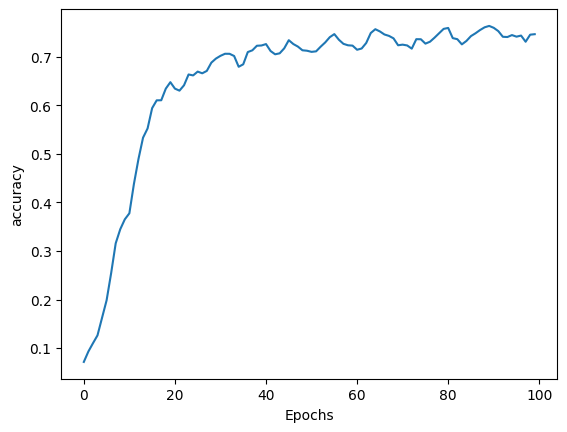

In [28]:
# Plot utility
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.show()

# Visualize the accuracy
plot_graphs(history, 'accuracy')

# **Actual Prediction of Words From Model**

In [36]:
from collections.abc import Sequence
seed_text = "help me obi-wan kenobi youre my only hope"
length = 10
for _ in range(length):
  sequence = vectorizer(seed_text)
  # Pass for padding
  sequence = tf.keras.utils.pad_sequences([sequence] , maxlen = max_seq-1 , padding = 'pre')
  # Pass for model prediction
  probabilities = model.predict(sequence , verbose = 0)
  predicted = np.argmax(probabilities , axis = -1)[0]
  if predicted != 0:
    word = vocabulary[predicted]
    seed_text += ' '+ word
print(seed_text)


help me obi-wan kenobi youre my only hope to the story at the wild eer as i love


In [37]:
from collections.abc import Sequence
seed_text = "help me obi-wan kenobi youre my only hope"
length = 20
for _ in range(length):
  sequence = vectorizer(seed_text)
  # Pass for padding
  sequence = tf.keras.utils.pad_sequences([sequence] , maxlen = max_seq-1 , padding = 'pre')
  # Pass for model prediction
  probabilities = model.predict(sequence , verbose = 0)
  choice = np.random.choice([1,2,3])

  # Sort the probabilities in ascending order
  # and get the random choice from the end of the array
  predicted = np.argsort(probabilities)[0][-choice]
  if predicted != 0:
    word = vocabulary[predicted]
    seed_text += ' '+ word
print(seed_text)


help me obi-wan kenobi youre my only hope in my sunday clothes sound of my love so dearly by side by love till i yearn die as plenty
